In [2]:
import pyarrow.feather as feather
import numpy as np
import pandas as pd
import os
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
from collections import Counter

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm,trange 
from pandas.tseries.offsets import Day, YearEnd, YearBegin
from datetime import datetime, timedelta

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report

In [3]:
pd.options.display.max_columns = 10 # 最大显示列数
pd.options.display.max_rows = 10 # 最大显示行数

## read character data

In [117]:
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
directory_path = os.getcwd()

In [118]:
raw_df = pd.read_feather(os.path.join(directory_path, 'chars60_raw_imputed.feather'))

In [119]:
raw_df.columns

Index(['gvkey', 'permno', 'sic', 'ret', 'exchcd', 'shrcd', 'adm', 'bm_ia',
       'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill', 'maxret', 'mom12m',
       'mom1m', 'mom36m', 'mom60m', 'mom6m', 're', 'rvar_capm', 'rvar_ff3',
       'rvar_mean', 'seas1a', 'std_dolvol', 'std_turn', 'zerotrade', 'me',
       'dy', 'turn', 'dolvol', 'abr', 'sue', 'cinvest', 'nincr', 'pscore',
       'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho',
       'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni',
       'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe',
       'rsup', 'sgr', 'sp', 'date', 'ffi49'],
      dtype='object')

In [120]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

['adm',
 'bm_ia',
 'mom12m',
 'mom36m',
 'mom60m',
 'mom6m',
 'seas1a',
 'abr',
 'sue',
 'cinvest',
 'nincr',
 'pscore',
 'acc',
 'bm',
 'agr',
 'alm',
 'ato',
 'cashdebt',
 'chcsho',
 'chpm',
 'chtx',
 'gma',
 'grltnoa',
 'lgr',
 'ni',
 'noa',
 'op',
 'pctacc',
 'rna',
 'roa',
 'roe',
 'rsup',
 'sgr']

In [121]:
raw_df['year'] = raw_df['date'].dt.year
raw_df = raw_df[raw_df['year'] >= 1972]
raw_df = raw_df.drop(['year'], axis=1)

In [122]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

no missing value!

In [123]:
raw_df

,gvkey,permno,sic,ret,exchcd,...,rsup,sgr,sp,date,ffi49
136,1010,10006,3743,0.004854,1.0,...,0.000047,0.042217,0.001158,1972-01-31,25
137,1010,10006,3743,-0.007729,1.0,...,0.000047,0.042217,0.001152,1972-02-29,25
138,1010,10006,3743,-0.068966,1.0,...,0.000048,0.042217,0.001175,1972-03-31,25
139,1010,10006,3743,-0.068783,1.0,...,0.000051,0.042217,0.001262,1972-04-30,25
140,1010,10006,3743,0.025000,1.0,...,-0.000004,-0.003038,0.001351,1972-05-31,25
...,...,...,...,...,...,...,...,...,...,...,...
551140,260778,90272,6324,-0.057476,1.0,...,0.000146,0.272945,0.001559,2019-08-31,46
551141,260778,90272,6324,-0.042735,1.0,...,0.000155,0.272945,0.001654,2019-09-30,46
551142,260778,90272,6324,0.144423,1.0,...,0.000162,0.272945,0.001728,2019-10-31,46
551143,260778,90272,6324,0.085873,1.0,...,0.000159,0.380853,0.001668,2019-11-30,46


## read macro data

In [124]:
macro_df = pd.read_csv(os.path.join(directory_path,'Macro.csv'))
macro_df = macro_df[macro_df['yyyymm']>=197201]

In [125]:
macro_df = pd.read_csv(r"C:\Users\hsx05\OneDrive\Desktop\summer project\Macro.csv")
macro_df = macro_df[macro_df['yyyymm']>=197201]

In [126]:
macro_df

,yyyymm,b/m,tbl,ntis,svar,d/p,e/p,dfy,tms
1212,197201,0.635357,0.0338,0.033075,0.000494,1.529644,1.258123,0.0104,0.0268
1213,197202,0.617586,0.0320,0.033030,0.000284,1.540497,1.266209,0.0096,0.0282
1214,197203,0.645902,0.0373,0.031723,0.000545,1.543056,1.266019,0.0100,0.0240
1215,197204,0.636784,0.0371,0.032492,0.000383,1.544956,1.263950,0.0094,0.0244
1216,197205,0.632442,0.0369,0.030657,0.000769,1.552395,1.267456,0.0093,0.0228
...,...,...,...,...,...,...,...,...,...
1795,202008,0.235975,0.0010,-0.008504,0.000743,1.772309,1.550421,0.0102,0.0055
1796,202009,0.241482,0.0011,-0.005698,0.004907,1.756971,1.534527,0.0105,0.0057
1797,202010,0.253146,0.0010,-0.001895,0.003661,1.746197,1.528413,0.0109,0.0069
1798,202011,0.226352,0.0009,-0.005262,0.002492,1.791974,1.578931,0.0100,0.0078


## merge macro & char

In [127]:
raw_df['yyyymm'] = raw_df['date'].dt.strftime('%Y%m').apply(int)
total_df = pd.merge(raw_df, macro_df, how='inner',on='yyyymm')
total_df.drop(columns='yyyymm',inplace=True)
total_df

,gvkey,permno,sic,ret,exchcd,...,svar,d/p,e/p,dfy,tms
0,1010,10006,3743,0.004854,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
1,1040,15763,3949,0.111399,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
2,1043,18980,5040,0.080000,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
3,1045,21020,4512,0.042945,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
4,1070,21549,3714,0.191489,2.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
...,...,...,...,...,...,...,...,...,...,...,...
462751,188255,12981,2430,0.048165,1.0,...,0.000746,1.722817,1.265919,0.0076,0.0371
462752,189491,13035,3561,0.001157,1.0,...,0.000746,1.722817,1.265919,0.0076,0.0371
462753,199356,13168,7370,-0.062160,3.0,...,0.000746,1.722817,1.265919,0.0076,0.0371
462754,260774,90199,6500,0.084983,1.0,...,0.000746,1.722817,1.265919,0.0076,0.0371


In [128]:
raw_tf = total_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

In [134]:
total_df.shrcd.nunique()

2

## information variable

- stock indicator: gvkey, permno
- time: datadate, date, year ('datadate' is the available time for data and 'date' is the date of return)
- industry: sic, ffi49
- exchange info: exchcd (exchange code), shrcd (share code, eg: 1=ordinary common share)
- return: ret: the dividend adjusted return (we also provide original return and return without dividend, you can keep them by modifing impute_rank_output_bchmk.py)
- market equity: me/rank_me


In [135]:
# need to turn some variables to dummy variables
def get_dummy_col(target_df, col_names):
    """turn the cols into multiple cols containing dummy variables, then drop the original columns

    Args:
        target_df (pandas dataframe): target dataframe
        col_names (list): list of columns that need to be turned into dummy variables
    """
    for col in col_names:        
        tmp_dummies = pd.get_dummies(target_df[col]).rename(columns=lambda x: f'{col}_' + str(x))
        target_df = pd.concat([target_df, tmp_dummies], axis=1)
        target_df.drop(col, inplace=True, axis = 1)
    return target_df 
dummy_col_list = ['ffi49'] # do we really need shrcd & exchcd? drop these two and only consider ffi49 as dummy
total_df = get_dummy_col(total_df, dummy_col_list)

In [136]:
total_df.set_index('date', inplace=True)
total_df.sort_values(by=['permno','date'])
total_df

,gvkey,permno,sic,ret,exchcd,...,ffi49_45,ffi49_46,ffi49_47,ffi49_48,ffi49_49
date,,,,,,,,,,,
1972-01-31,1010,10006,3743,0.004854,1.0,...,0,0,0,0,0
1972-01-31,1040,15763,3949,0.111399,1.0,...,0,0,0,0,0
1972-01-31,1043,18980,5040,0.080000,1.0,...,0,0,0,0,0
1972-01-31,1045,21020,4512,0.042945,1.0,...,0,0,0,0,0
1972-01-31,1070,21549,3714,0.191489,2.0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,188255,12981,2430,0.048165,1.0,...,0,0,0,0,0
2013-12-31,189491,13035,3561,0.001157,1.0,...,0,0,0,0,0
2013-12-31,199356,13168,7370,-0.062160,3.0,...,0,0,0,0,0


In [137]:
total_df.columns

Index(['gvkey', 'permno', 'sic', 'ret', 'exchcd', 'shrcd', 'adm', 'bm_ia',
       'herf', 'hire',
       ...
       'ffi49_40', 'ffi49_41', 'ffi49_42', 'ffi49_43', 'ffi49_44', 'ffi49_45',
       'ffi49_46', 'ffi49_47', 'ffi49_48', 'ffi49_49'],
      dtype='object', length=123)

<AxesSubplot:xlabel='date'>

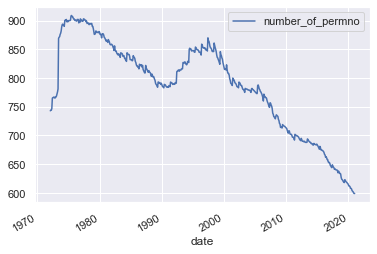

In [138]:
each_month_permno_num = pd.DataFrame(Counter(total_df.reset_index().date).items(), columns=['date', 'number_of_permno'])
each_month_permno_num.plot(x='date', y='number_of_permno')

In [139]:
# set character features list
features_list = total_df.columns.tolist()
remove_list = {'gvkey', 'permno', 'ret','sic','exchcd','shrcd'}
features_list = [ele for ele in features_list if ele not in remove_list]
len(features_list)

117

In [140]:
print(features_list)

['adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill', 'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 're', 'rvar_capm', 'rvar_ff3', 'rvar_mean', 'seas1a', 'std_dolvol', 'std_turn', 'zerotrade', 'me', 'dy', 'turn', 'dolvol', 'abr', 'sue', 'cinvest', 'nincr', 'pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho', 'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni', 'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe', 'rsup', 'sgr', 'sp', 'b/m', 'tbl', 'ntis', 'svar', 'd/p', 'e/p', 'dfy', 'tms', 'ffi49_1', 'ffi49_2', 'ffi49_3', 'ffi49_4', 'ffi49_5', 'ffi49_6', 'ffi49_7', 'ffi49_8', 'ffi49_9', 'ffi49_10', 'ffi49_11', 'ffi49_12', 'ffi49_13', 'ffi49_14', 'ffi49_15', 'ffi49_16', 'ffi49_17', 'ffi49_18', 'ffi49_19', 'ffi49_21', 'ffi49_22', 'ffi49_23', 'ffi49_24', 'ffi49_25', 'ffi49_26', 'ffi49_27', 'ffi49_28', 'ffi49_29', 'ffi49_30', 'ffi49_31', 'ffi49_32', 'ffi49_33', 'ffi49_34', 'ffi49_35', 'ffi49_36', 'ffi49_37

## check distribution and correlation 

C:\Users\hsx05\AppData\Local\Temp/ipykernel_19972/3608439455.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  total_df[features_list[:69]].hist(layout=(28, 6), bins=np.linspace(-1,1,50), ax=ax);


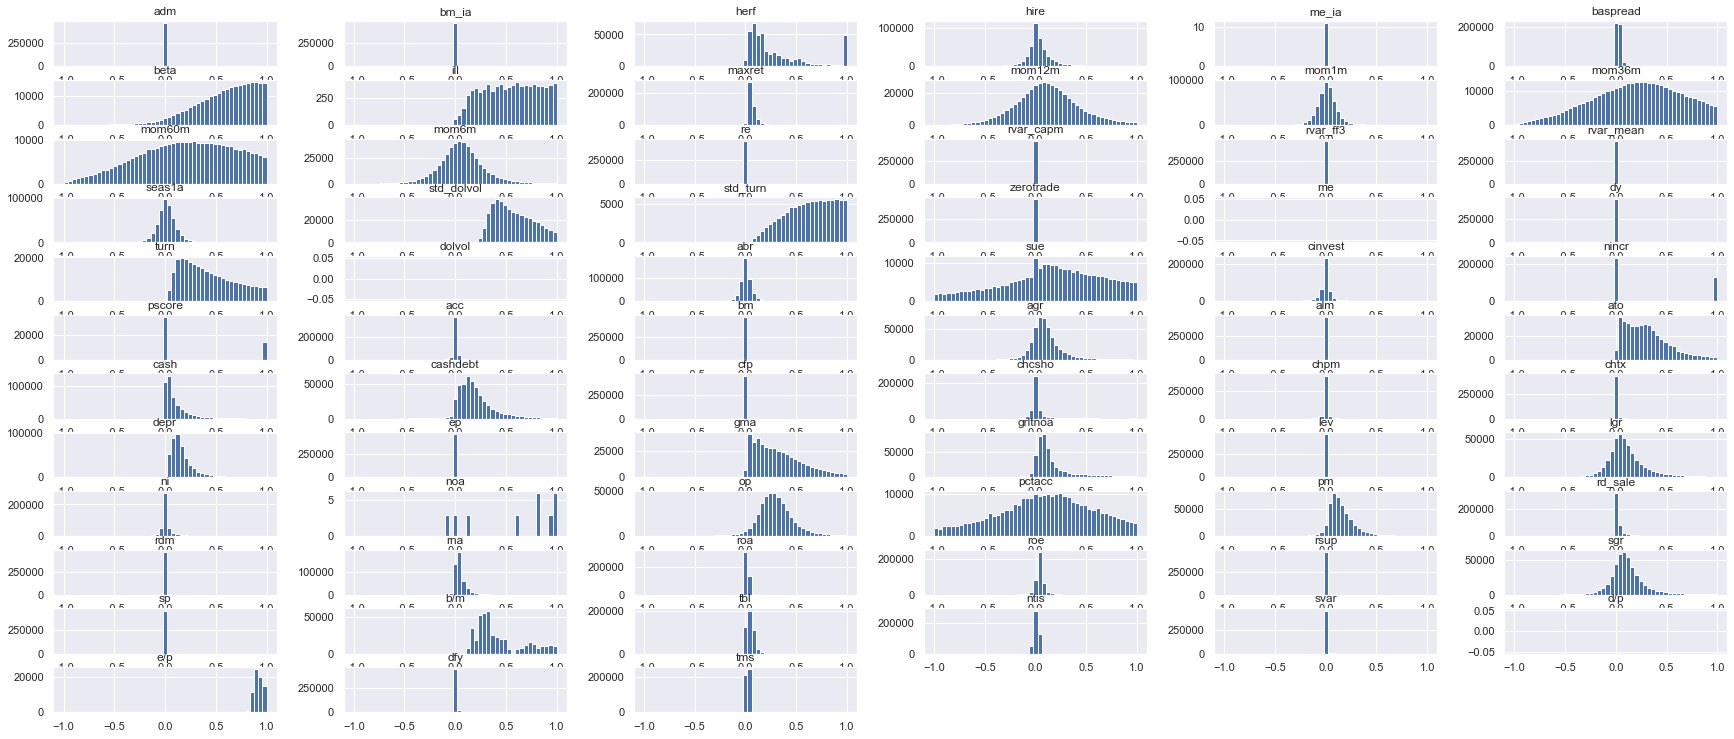

In [144]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
total_df[features_list[:69]].hist(layout=(28, 6), bins=np.linspace(-1,1,50), ax=ax);

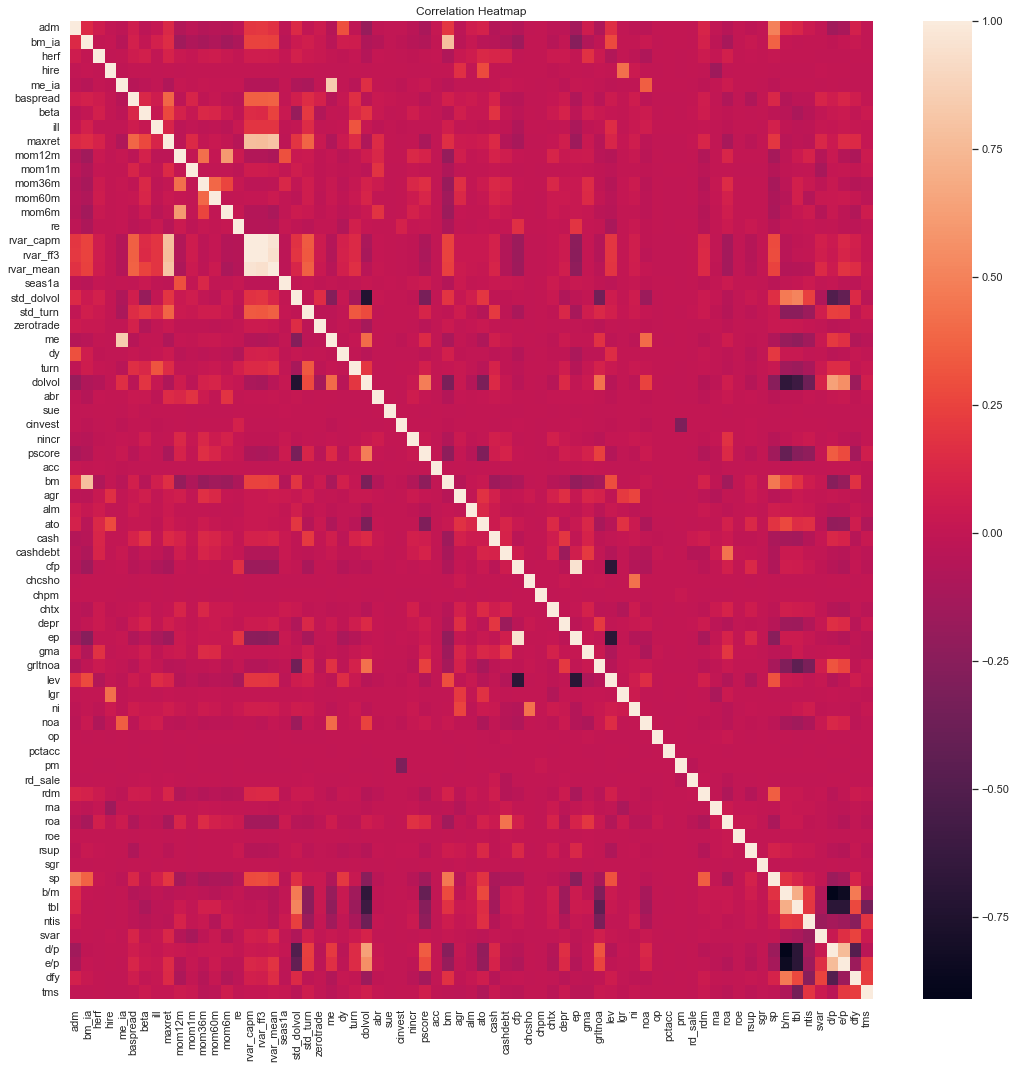

<Figure size 432x288 with 0 Axes>

In [143]:
plt.figure(figsize = (18,18))
sns.heatmap(data=total_df[features_list[:69]].corr())
plt.title('Correlation Heatmap')
plt.show()
plt.gcf().clear()

In [219]:
table_for_interaction = total_df[features_list[:69]]
single_features = features_list[:61]
macro_features = features_list[61:69]

interaction_table = pd.DataFrame(data = None, index = table_for_interaction.index)
for i in single_features:
    for j in macro_features:
        interaction_table[i + '+' + j] = table_for_interaction[i] * table_for_interaction[j]

C:\Users\hsx05\AppData\Local\Temp/ipykernel_19972/2151169675.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  interaction_table[i + '+' + j] = table_for_interaction[i] * table_for_interaction[j]


In [230]:
interaction_table

,adm+b/m,adm+tbl,adm+ntis,adm+svar,adm+d/p,...,sp+svar,sp+d/p,sp+e/p,sp+dfy,sp+tms
date,,,,,,,,,,,
1972-01-31,3.791261e-06,2.016892e-07,1.973637e-07,2.949078e-09,0.000009,...,5.721862e-07,0.001771,0.001457,1.204066e-05,0.000031
1972-01-31,2.352534e-05,1.251511e-06,1.224671e-06,1.829947e-08,0.000057,...,3.621838e-07,0.001121,0.000922,7.621528e-06,0.000020
1972-01-31,2.352534e-05,1.251511e-06,1.224671e-06,1.829947e-08,0.000057,...,7.375683e-07,0.002283,0.001878,1.552084e-05,0.000040
1972-01-31,1.961296e-05,1.043379e-06,1.021002e-06,1.525617e-08,0.000047,...,5.659508e-07,0.001752,0.001441,1.190945e-05,0.000031
1972-01-31,2.352534e-05,1.251511e-06,1.224671e-06,1.829947e-08,0.000057,...,3.358632e-06,0.010395,0.008550,7.067657e-05,0.000182
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,7.535672e-06,1.732861e-08,3.006245e-07,1.845586e-08,0.000043,...,3.765140e-07,0.000870,0.000639,3.838187e-06,0.000019
2013-12-31,8.049202e-07,1.850950e-09,3.211110e-08,1.971357e-09,0.000005,...,4.372021e-07,0.001010,0.000742,4.456841e-06,0.000022
2013-12-31,4.666211e-06,1.073016e-08,1.861516e-07,1.142817e-08,0.000026,...,5.609332e-08,0.000130,0.000095,5.718157e-07,0.000003


In [224]:
new_total_df = pd.concat([total_df, interaction_table], axis=1)

In [225]:
new_total_df    

,gvkey,permno,sic,ret,exchcd,...,sp+svar,sp+d/p,sp+e/p,sp+dfy,sp+tms
date,,,,,,,,,,,
1972-01-31,1010,10006,3743,0.004854,1.0,...,5.721862e-07,0.001771,0.001457,1.204066e-05,0.000031
1972-01-31,1040,15763,3949,0.111399,1.0,...,3.621838e-07,0.001121,0.000922,7.621528e-06,0.000020
1972-01-31,1043,18980,5040,0.080000,1.0,...,7.375683e-07,0.002283,0.001878,1.552084e-05,0.000040
1972-01-31,1045,21020,4512,0.042945,1.0,...,5.659508e-07,0.001752,0.001441,1.190945e-05,0.000031
1972-01-31,1070,21549,3714,0.191489,2.0,...,3.358632e-06,0.010395,0.008550,7.067657e-05,0.000182
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,188255,12981,2430,0.048165,1.0,...,3.765140e-07,0.000870,0.000639,3.838187e-06,0.000019
2013-12-31,189491,13035,3561,0.001157,1.0,...,4.372021e-07,0.001010,0.000742,4.456841e-06,0.000022
2013-12-31,199356,13168,7370,-0.062160,3.0,...,5.609332e-08,0.000130,0.000095,5.718157e-07,0.000003


In [232]:
new_features_list = new_total_df.columns
remove_list = {'gvkey', 'permno', 'ret','sic','exchcd','shrcd','b/m', 'tbl', 'ntis', 'svar', 'd/p', 'e/p', 'dfy', 'tms'}
new_features_list = [ele for ele in new_features_list if ele not in remove_list]
len(new_features_list)

597

## normalization 

In [23]:
scaler = StandardScaler()
scaler.fit(total_df[features_list[:69]])
normalized = scaler.transform(total_df[features_list[:69]])
normalized_data = pd.DataFrame(normalized , columns=features_list[:69], index=total_df.index)

print("The shape of normalised numerical data : " , normalized.shape)
normalized_data

The shape of normalised numerical data :  (462756, 69)


,adm,bm_ia,herf,hire,me_ia,...,svar,d/p,e/p,dfy,tms
date,,,,,,,,,,,
1972-01-31,-0.266273,0.060930,1.331469,-0.018029,0.006061,...,-0.373083,-0.252113,0.126767,-0.107256,0.426510
1972-01-31,0.014889,-0.276326,-0.500789,-0.010624,0.019947,...,-0.373083,-0.252113,0.126767,-0.107256,0.426510
1972-01-31,0.014889,0.113205,2.258603,-0.021854,0.000136,...,-0.373083,-0.252113,0.126767,-0.107256,0.426510
1972-01-31,-0.040853,-0.850659,-0.833250,-0.016621,0.021434,...,-0.373083,-0.252113,0.126767,-0.107256,0.426510
1972-01-31,0.014889,1.557838,-0.219789,-0.013646,-0.094976,...,-0.373083,-0.252113,0.126767,-0.107256,0.426510
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,-0.096199,0.068467,-0.173786,-0.013646,0.071497,...,-0.325290,0.772511,0.164545,-0.731845,1.265465
2013-12-31,-0.296352,-0.052338,-0.518638,-0.012219,-0.253867,...,-0.325290,0.772511,0.164545,-0.731845,1.265465
2013-12-31,-0.181529,-0.294847,-0.156035,0.009551,-3.528136,...,-0.325290,0.772511,0.164545,-0.731845,1.265465


In [24]:
normalized_data.describe()

,adm,bm_ia,herf,hire,me_ia,...,svar,d/p,e/p,dfy,tms
count,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,...,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05
mean,2.841376e-15,-2.038921e-17,-2.332824e-15,-2.232020e-15,1.067552e-17,...,-4.380682e-14,2.591064e-13,7.438468e-14,1.314793e-13,1.420326e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.202886e-01,-1.567056e+01,-1.039444e+00,-1.028637e-01,-2.200163e+01,...,-4.384943e-01,-2.023135e+00,-1.974134e+00,-1.200287e+00,-1.756402e+00
25%,-2.661362e-01,-2.693524e-01,-7.353735e-01,-1.577029e-02,-1.183916e-01,...,-3.122594e-01,-8.135736e-01,-7.482009e-01,-6.872313e-01,-8.685757e-01
50%,-1.820625e-01,-4.781521e-02,-4.402527e-01,-1.191368e-02,-1.113683e-02,...,-2.084208e-01,-5.456773e-02,9.599857e-02,-3.080166e-01,2.960172e-03
75%,7.905231e-03,1.431363e-01,4.222584e-01,-5.272497e-03,1.320859e-02,...,-1.574563e-02,7.880238e-01,6.073664e-01,4.057994e-01,7.930441e-01
max,1.844458e+02,1.688836e+02,2.258603e+00,1.894846e+02,6.208946e+01,...,1.344457e+01,2.054929e+00,4.208580e+00,5.112524e+00,1.949662e+00


## data split & Neural Network model

In [48]:
X_total = normalized_data
Y_total = pd.DataFrame(total_df['ret'], index=total_df.index)

- total:1972-2020 49 years
- training_length: 32 years // 20 // 14
- valid_length: 7 years // 10 // 6
- testing_length: 7 years // 16 // 26

- Hyperparameters
 - L1 penalty λ1 ∈ (10−5, 10−3) 
 - Learning Rate LR ∈ {0.001, 0.01} 
 - Batch Size=10000 
 - Epochs=100 
 - Patience=5 
 - Adam Para.= Default 
 - Ensemble=10

In [49]:
class model(object):
    '''
    params:
        chardf: character feature dataframe, set date as index and 123 feature columns
        retdf: true return data, set date as index 
        first_train_start_date:初次训练时，训练集的开始日期。
        last_train_start_date:最后一次训练时，训练集的开始日期。
        train_period: x year
        valid_period： x year
        test_period: x year 
        freq: expanding frequency，默认为'y'，每个年滚动一次
    '''
    
    def __init__(self,chardf,retdf,first_train_start_date,last_train_start_date, train_period, valid_period, test_period, freq):
        self.chardf = chardf
        self.retdf = retdf
        self.first_train_start_date = first_train_start_date 
        self.last_train_start_date = last_train_start_date
        self.train_period = train_period
        self.valid_period = valid_period
        self.test_period = test_period
        self.freq = freq 
           
    def NN1(self): 
        '''
        single hidden layer of 32 neurons
        '''
        model = Sequential()        
        model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1(10e-5)))
        model.add(Dropout(0.5)
        model.add(Dense(1, activation='relu'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, metrics=['mse'])
        
        return model     
    
    def NN2(self):  
        '''
        two hidden layers with 32, 16, neurons
        '''
        model = Sequential()        
        model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1(10e-5)))
        model.add(Dropout(0.5)
        model.add(Dense(16, activation='relu'),kernel_regularizer=regularizers.l1(10e-5))
        model.add(Dropout(0.5)
        model.add(Dense(1, activation='relu'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, metrics=['mse'])
        
        return model        
    
    def NN3(self): 
        '''
        three hidden layers with 32, 16, 8 neurons
        '''
        model = Sequential()        
        model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1(10e-5)))
        model.add(Dropout(0.5)          
        model.add(Dense(16, activation='relu'),kernel_regularizer=regularizers.l1(10e-5))       
        model.add(Dropout(0.5)
        model.add(Dense(8, activation='relu'),kernel_regularizer=regularizers.l1(10e-5))
        model.add(Dropout(0.5)
        model.add(Dense(1, activation='relu'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, metrics=['mse'])
        
        return model
    
    def NN4(self): 
        '''
        four hidden layers with 32, 16, 8,4 neurons
        '''
        model = Sequential()        
        model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1(10e-5)))
        model.add(Dropout(0.5)
        model.add(Dense(16, activation='relu'),kernel_regularizer=regularizers.l1(10e-5))  
        model.add(Dropout(0.5)
        model.add(Dense(8, activation='relu'),kernel_regularizer=regularizers.l1(10e-5))
        model.add(Dropout(0.5)
        model.add(Dense(4, activation='relu'),kernel_regularizer=regularizers.l1(10e-5))
        model.add(Dropout(0.5)
        model.add(Dense(1, activation='relu'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, metrics=['mse'])
        
        return model
    
    def NN5(self):   
        '''
        five hidden layers with 32, 16, 8, 4, 2 neurons
        '''
        model = Sequential()        
        model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l1(10e-5)))
        model.add(Dropout(0.5)
        model.add(Dense(16, activation='relu'),kernel_regularizer=regularizers.l1(10e-5))
        model.add(Dropout(0.5)
        model.add(Dense(8, activation='relu'),kernel_regularizer=regularizers.l1(10e-5))
        model.add(Dropout(0.5)
        model.add(Dense(4, activation='relu'),kernel_regularizer=regularizers.l1(10e-5))
        model.add(Dropout(0.5)
        model.add(Dense(2, activation='relu'),kernel_regularizer=regularizers.l1(10e-5))
        model.add(Dropout(0.5)
        model.add(Dense(1, activation='relu'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, metrics=['mse'])
                
        return model
    
    # R_square_oos
    def r2_oos(self, ret, pred):
        sum_of_sq_res = np.nansum(np.power((ret - pred), 2))
        sum_of_sq_total = np.nansum(np.power(ret, 2))
    
        return 1-sum_of_sq_res/sum_of_sq_total

    
    def predict_ret(self):
        train_start_list = pd.date_range(self.first_train_start_date,self.last_train_start_date,freq=self.freq)
        preddf = pd.DataFrame()
        rsq_oos = pd.DataFrame()
        
        rsq_oos_NN1 = []
        rsq_oos_NN2 = []
        rsq_oos_NN3 = []
        rsq_oos_NN4 = []
        rsq_oos_NN5 = []
        
         # rsquared reduction
        features = self.chardf.columns
        column_name=['NN1','NN2','NN3','NN4','NN5']
        rsquared_df = pd.DataFrame(columns=column_name, index=features)
        
        
        for i in column_name:
            rsquared_df[i] = np.zeros((len(rsquared_df),1)).tolist()
        
        
        for start_date in tqdm(train_start_list):
            end_date = start_date + self.train_period * YearEnd()
            valid_date = end_date + self.valid_period * YearEnd() 
            test_date = valid_date + self.test_period * YearEnd()

            # training set
            train_x = self.chardf.loc[start_date.strftime('%Y%m%d'):end_date.strftime('%Y%m%d')]
            train_y = self.retdf.loc[start_date.strftime('%Y%m%d'):end_date.strftime('%Y%m%d')] 

            # validation set
            valid_x = self.chardf.loc[(end_date + timedelta(days=1)).strftime('%Y%m%d'):valid_date.strftime('%Y%m%d')]
            valid_y = self.retdf.loc[(end_date + timedelta(days=1)).strftime('%Y%m%d'):valid_date.strftime('%Y%m%d')]
            
            # testing set
            test_x = self.chardf.loc[(valid_date + timedelta(days=1)).strftime('%Y%m%d'):test_date.strftime('%Y%m%d')]
            test_y = self.retdf.loc[(valid_date + timedelta(days=1)).strftime('%Y%m%d'):test_date.strftime('%Y%m%d')]
            
            # temporary prediction dataframe
            temp_preddf = pd.DataFrame() 
            temp_preddf['real_y'] = test_y.iloc[:,0]
            
            # earlystopping rules
            callback = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
            
#             params ={
#                 'learning_rate':(0.001, 0.01),
#                 'k_reg': (10e-5, 10e-3),
#             }
            
            
            # NN1    
            regr_NN1 = self.NN1()
            regr_NN1.fit(train_x, train_y, epochs=100,
                         validation_data=(valid_x, valid_y), 
                         callbacks=callback, 
                         batch_size=10000)
            
            predict_yNN1 = regr_NN1.predict(test_x)
            temp_preddf['NN1_y'] = predict_yNN1
            
            oos1 = self.r2_oos(temp_preddf['real_y'], temp_preddf['NN1_y'])
            rsq_oos_NN1.append(oos1)
            
            
#             regr_NN1 = KerasClassifier(self.NN1())
# #             regr_NN1.fit(train_x, train_y, epochs=100,
# #                          validation_data=(valid_x, valid_y), 
# #                          callbacks=callback, 
# #                          batch_size=10000)
              
#             NN1_search_cv = GridSearchCV(estimator = regr_NN1, param_grid=params,n_jobs= -1, cv=3)
#             NN1_search_cv.fit(train_x, train_y, epochs=100,
#                          validation_data=(valid_x, valid_y), 
#                          callbacks=callback, 
#                          batch_size=10000)
            
#             regr_NN1_mod = NN1_search_cv.best_estimator_.model
#             predict_yNN1 = regr_NN1_mod.predict(test_x)
#             temp_preddf['NN1_y'] = predict_yNN1
            
#             oos1 = self.r2_oos(temp_preddf['real_y'], temp_preddf['NN1_y'])
#             rsq_oos_NN1.append(oos1)


            # NN2
            regr_NN2 = self.NN2()
            regr_NN2.fit(train_x, train_y, epochs=100,
                         validation_data=(valid_x, valid_y), 
                         callbacks=callback, 
                         batch_size=10000)
            
            predict_yNN2 = regr_NN2.predict(test_x)
            temp_preddf['NN2_y'] = predict_yNN2
            
            oos2 = self.r2_oos(temp_preddf['real_y'], temp_preddf['NN2_y'])
            rsq_oos_NN2.append(oos2)
            

            # NN3
            regr_NN3 = self.NN3()
            regr_NN3.fit(train_x, train_y, epochs=100,
                         validation_data=(valid_x, valid_y), 
                         callbacks=callback, 
                         batch_size=10000)
            predict_yNN3 = regr_NN3.predict(test_x)
            temp_preddf['NN3_y'] = predict_yNN3
            
            oos3 = self.r2_oos(temp_preddf['real_y'], temp_preddf['NN3_y'])
            rsq_oos_NN3.append(oos3)


            # NN4 
            regr_NN4 = self.NN4()
            regr_NN4.fit(train_x, train_y, epochs=100,
                         validation_data=(valid_x, valid_y), 
                         callbacks=callback, 
                         batch_size=10000)
            predict_yNN4 = regr_NN4.predict(test_x)
            temp_preddf['NN4_y'] = predict_yNN4
            
            oos4 = self.r2_oos(temp_preddf['real_y'], temp_preddf['NN4_y'])
            rsq_oos_NN4.append(oos4)


            # NN5
            regr_NN5 = self.NN5()
            regr_NN5.fit(train_x, train_y, epochs=100,
                         validation_data=(valid_x, valid_y), 
                         callbacks=callback, 
                         batch_size=10000)
            predict_yNN5 = regr_NN5.predict(test_x)
            temp_preddf['NN5_y'] = predict_yNN5
            
            oos5 = self.r2_oos(temp_preddf['real_y'], temp_preddf['NN5_y'])
            rsq_oos_NN5.append(oos5)

            
            # append temporary predition to final prediction dataframe
            preddf = preddf.append(temp_preddf)
                      
            
            for feature in features:
                new_test_x = test_x.copy(deep=True)
                new_test_x[feature] = 0
                
                new_pred_NN1 = regr_NN1.predict(new_test_x)
                new_rsq_1 = self.r2_oos(test_y, new_pred_NN1)
                rsquared_df.loc[feature, 'NN1'].append(new_rsq_1)
                
                new_pred_NN2 = regr_NN2.predict(new_test_x)
                new_rsq_2 = self.r2_oos(test_y, new_pred_NN2)
                rsquared_df.loc[feature, 'NN2'].append(new_rsq_2)
                
                new_pred_NN3 = regr_NN3.predict(new_test_x)
                new_rsq_3 = self.r2_oos(test_y, new_pred_NN3)
                rsquared_df.loc[feature, 'NN3'].append(new_rsq_3)                
                
                new_pred_NN4 = regr_NN4.predict(new_test_x)
                new_rsq_4 = self.r2_oos(test_y, new_pred_NN4)
                rsquared_df.loc[feature, 'NN4'].append(new_rsq_4)
                
                new_pred_NN5 = regr_NN5.predict(new_test_x)
                new_rsq_5 = self.r2_oos(test_y, new_pred_NN5)
                rsquared_df.loc[feature, 'NN5'].append(new_rsq_5)
                
        # final r2_oos result
        rsq_oos['NN1'] = rsq_oos_NN1
        rsq_oos['NN2'] = rsq_oos_NN2
        rsq_oos['NN3'] = rsq_oos_NN3
        rsq_oos['NN4'] = rsq_oos_NN4
        rsq_oos['NN5'] = rsq_oos_NN5
        
            
        return preddf, rsq_oos, rsquared_df
 


In [50]:
# 32, 7, 7 rolling 4 times 
basic_2_factors = model(X_total, Y_total, first_train_start_date='19720101', last_train_start_date='19750101', train_period = 32, valid_period = 7, test_period = 7, freq='AS-JAN')

# 20, 10, 16 rolling 4 times 
basic_2_factors = model(X_total, Y_total, first_train_start_date='19720101', last_train_start_date='19750101', train_period = 20, valid_period = 10, test_period = 16, freq='AS-JAN')

# 14, 6, 26 rolling 4 times 
basic_2_factors = model(X_total, Y_total, first_train_start_date='19720101', last_train_start_date='19750101', train_period = 14, valid_period = 6, test_period = 26 freq='AS-JAN')


In [53]:
preddf = basic_2_factors.predict_ret()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Epoch 1/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0235 - mse: 0.0548 - val_loss: 0.0201 - val_mse: 0.1369
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0172 - mse: 0.0429 - val_loss: 0.0143 - val_mse: 0.0925
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0119 - mse: 0.0344 - val_loss: 0.0095 - val_mse: 0.0591
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0075 - mse: 0.0286 - val_loss: 0.0057 - val_mse: 0.0410
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0042 - mse: 0.0229 - val_loss: 0.0029 - val_mse: 0.0281
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0019 - mse: 0.0175 - val_loss: 0.0010 - val_mse: 0.0172
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 5.2593e-04 - mse: 0.0143 - val_loss: 1.4794e-04 - val_mse: 0.0138
Epoch 8/100
33/33 [==============================] - 0s 7ms/step - loss: 6

 25%|████████████████████▊                                                              | 1/4 [10:35<31:47, 635.85s/it]

Epoch 1/100
33/33 [==============================] - 1s 11ms/step - loss: 0.0236 - mse: 0.7313 - val_loss: 0.0203 - val_mse: 1.0083
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0174 - mse: 0.4735 - val_loss: 0.0145 - val_mse: 0.5876
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0121 - mse: 0.2899 - val_loss: 0.0098 - val_mse: 0.3312
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0078 - mse: 0.1675 - val_loss: 0.0059 - val_mse: 0.1702
Epoch 5/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0044 - mse: 0.0831 - val_loss: 0.0030 - val_mse: 0.0659
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0020 - mse: 0.0319 - val_loss: 0.0011 - val_mse: 0.0206
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 5.5390e-04 - mse: 0.0156 - val_loss: 1.5574e-04 - val_mse: 0.0140
Epoch 8/100
33/33 [==============================] - 0s 7ms/step - loss: 7

 50%|█████████████████████████████████████████▌                                         | 2/4 [20:57<20:55, 627.70s/it]

Epoch 1/100
33/33 [==============================] - 1s 9ms/step - loss: 0.0238 - mse: 0.7736 - val_loss: 0.0204 - val_mse: 0.8995
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0175 - mse: 0.5146 - val_loss: 0.0146 - val_mse: 0.4951
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0122 - mse: 0.3145 - val_loss: 0.0097 - val_mse: 0.2804
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0078 - mse: 0.1730 - val_loss: 0.0059 - val_mse: 0.1530
Epoch 5/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0044 - mse: 0.0845 - val_loss: 0.0030 - val_mse: 0.0782
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 0.0020 - mse: 0.0360 - val_loss: 0.0011 - val_mse: 0.0302
Epoch 7/100
33/33 [==============================] - 0s 8ms/step - loss: 5.7130e-04 - mse: 0.0164 - val_loss: 1.6524e-04 - val_mse: 0.0145
Epoch 8/100
33/33 [==============================] - 0s 7ms/step - loss: 7.

 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [30:47<10:10, 610.11s/it]

Epoch 1/100
32/32 [==============================] - 1s 12ms/step - loss: 0.0231 - mse: 0.2506 - val_loss: 0.0199 - val_mse: 0.6323
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0171 - mse: 0.1584 - val_loss: 0.0143 - val_mse: 0.4056
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0120 - mse: 0.0967 - val_loss: 0.0097 - val_mse: 0.2342
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0078 - mse: 0.0584 - val_loss: 0.0060 - val_mse: 0.1167
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0046 - mse: 0.0332 - val_loss: 0.0032 - val_mse: 0.0468
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0022 - mse: 0.0191 - val_loss: 0.0013 - val_mse: 0.0213
Epoch 7/100
32/32 [==============================] - 0s 7ms/step - loss: 6.9875e-04 - mse: 0.0139 - val_loss: 2.5828e-04 - val_mse: 0.0145
Epoch 8/100
32/32 [==============================] - 0s 6ms/step - loss: 1

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [40:39<00:00, 609.79s/it]


## Prediction & OOS R2 & Feather importance

In [54]:
pred_result = preddf[0].copy(deep=True)
pred_result

,real_y,NN1_y,NN2_y,NN3_y,NN4_y,NN5_y
date,,,,,,
2011-01-31,-0.094994,0.000000,0.000000,0.000000,0.000389,0.000000
2011-01-31,-0.005187,0.000000,0.000000,0.000000,0.000054,0.000021
2011-01-31,-0.048215,0.000000,0.000000,0.000134,0.000170,0.000000
2011-01-31,-0.042787,0.000000,0.000000,0.000000,0.000553,0.000000
2011-01-31,0.079646,0.000000,0.000000,0.000246,0.000334,0.000000
...,...,...,...,...,...,...
2020-12-31,0.111749,0.000176,0.000880,0.000109,0.000120,0.000197
2020-12-31,0.026587,0.000000,0.001250,0.000000,0.000204,0.000000
2020-12-31,0.060644,0.000000,0.001414,0.000000,0.000182,0.000160


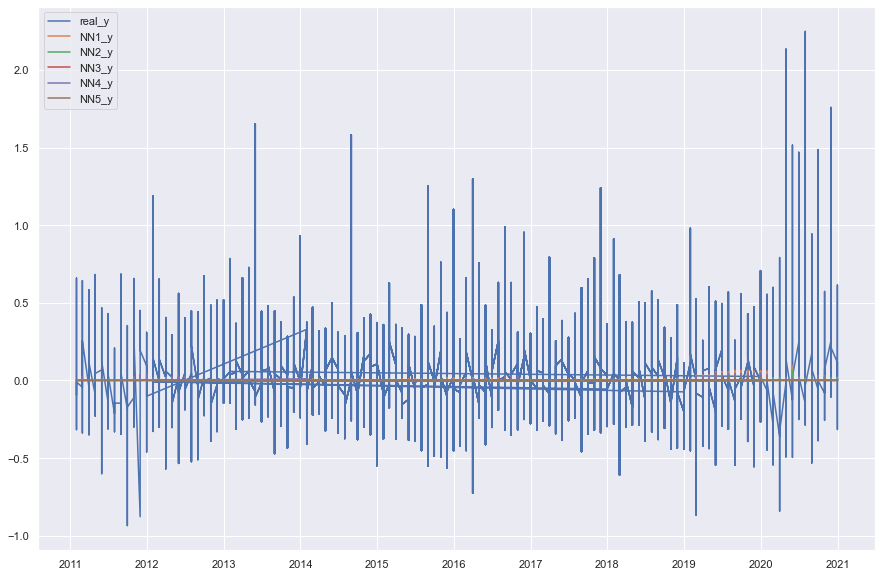

In [55]:
plt.figure(figsize=(15,10))
plt.plot(pred_result)
plt.legend(['real_y','NN1_y','NN2_y','NN3_y','NN4_y','NN5_y'])

In [122]:
r2_oos = preddf[1].copy(deep=True)

# calculate r2oos each rolling and make average
r2_oos_NN = pd.DataFrame({'model':r2_oos.mean().index, 'r2_oos':r2_oos.mean()})
r2_oos_NN = r2_oos_NN.reset_index(drop = True)
r2_oos_NN

,model,r2_oos
0,NN1,0.001040
1,NN2,0.000716
2,NN3,0.000311
3,NN4,0.000717
4,NN5,0.000203


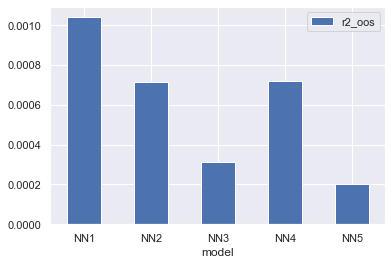

In [114]:
# plot r2_oos

ax = r2_oos_NN.plot.bar(x='model', y='r2_oos', rot=0)

In [135]:
#调整rsquared_df -- calculate average of rsquared, rsquared reduction, rsquared normalized
rsquared_df = preddf[2].copy(deep=True)

for i in rsquared_df.columns:
    rsquared_df[i] = pd.DataFrame(rsquared_df[i].values.tolist()).drop(0,1).values.tolist()
    rsquared_df[i] = rsquared_df[i].apply(np.mean)
    
oos_feature = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=X_total.columns)

for i in range(len(rsquared_df.columns)):
    oos_feature.iloc[:,i] = r2_oos_NN['r2_oos'][i]

rsquared_reduction = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=X_total.columns)
rsquared_normalized = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=X_total.columns)

for i in ['NN1','NN2','NN3','NN4','NN5']:
    rsquared_reduction[i] = np.abs(oos_feature.loc[:,i] - rsquared_df.loc[:,i])
    rsquared_normalized[i] = rsquared_reduction.loc[:,i] / rsquared_reduction.loc[:,i].sum()

C:\Users\hsx05\AppData\Local\Temp/ipykernel_14088/630490836.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  rsquared_df[i] = pd.DataFrame(rsquared_df[i].values.tolist()).drop(0,1).values.tolist()


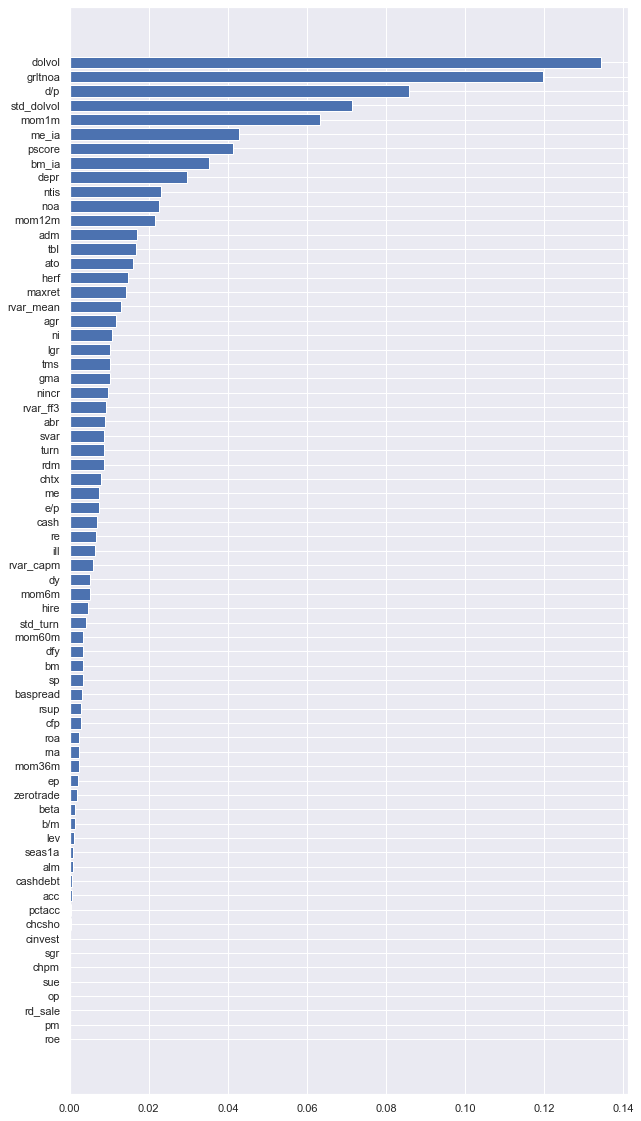

In [137]:
# plot features importance
NN1_FI = pd.DataFrame(rsquared_normalized['NN1'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN1_FI.index, NN1_FI['NN1'])
plt.show()

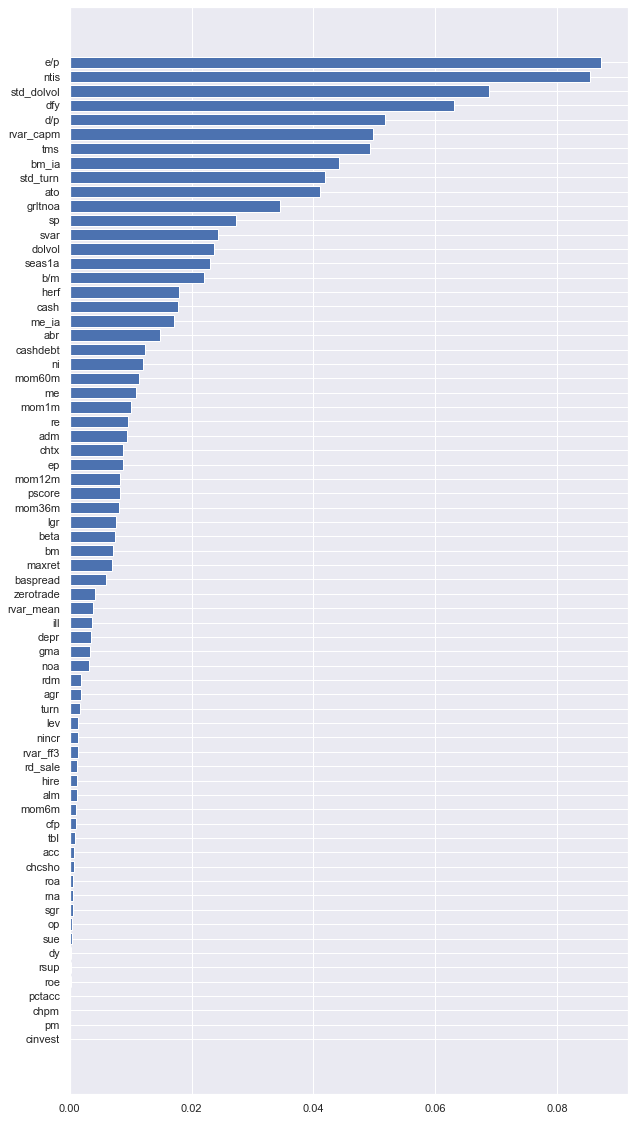

In [138]:
NN2_FI = pd.DataFrame(rsquared_normalized['NN2'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN2_FI.index, NN2_FI['NN2'])
plt.show()

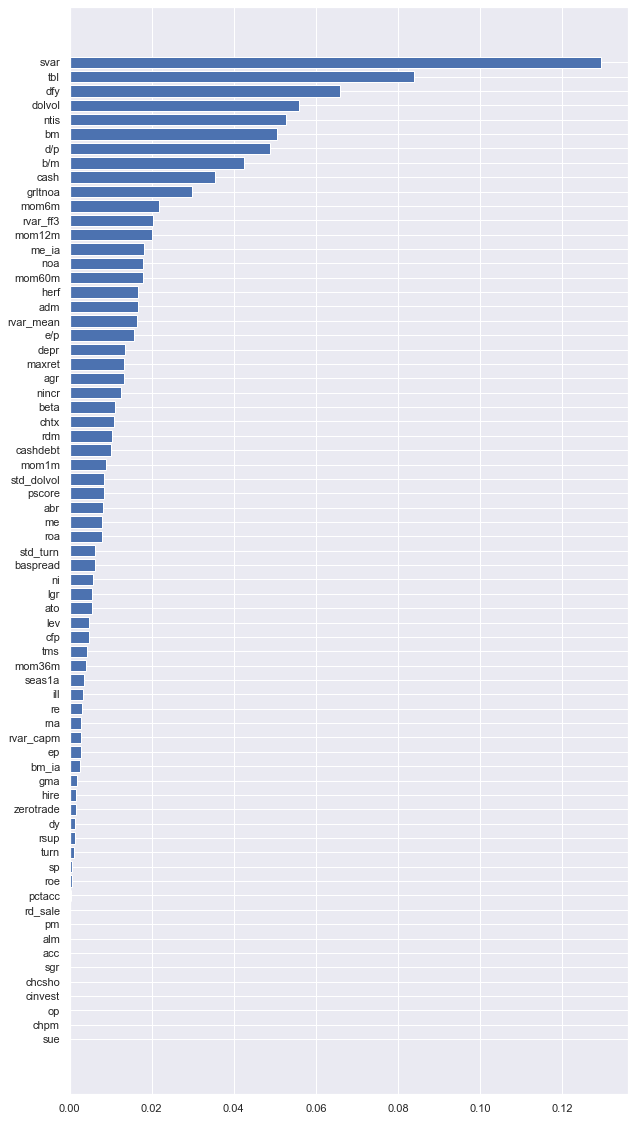

In [139]:
NN3_FI = pd.DataFrame(rsquared_normalized['NN3'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN3_FI.index, NN3_FI['NN3'])
plt.show()

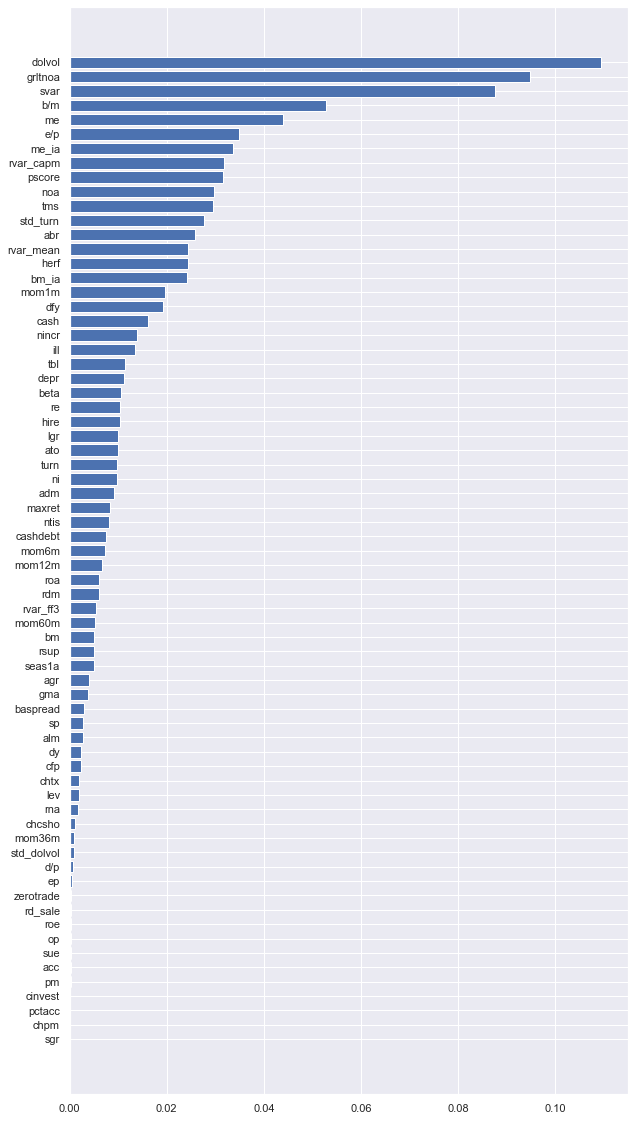

In [140]:
NN4_FI = pd.DataFrame(rsquared_normalized['NN4'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN4_FI.index, NN4_FI['NN4'])
plt.show()

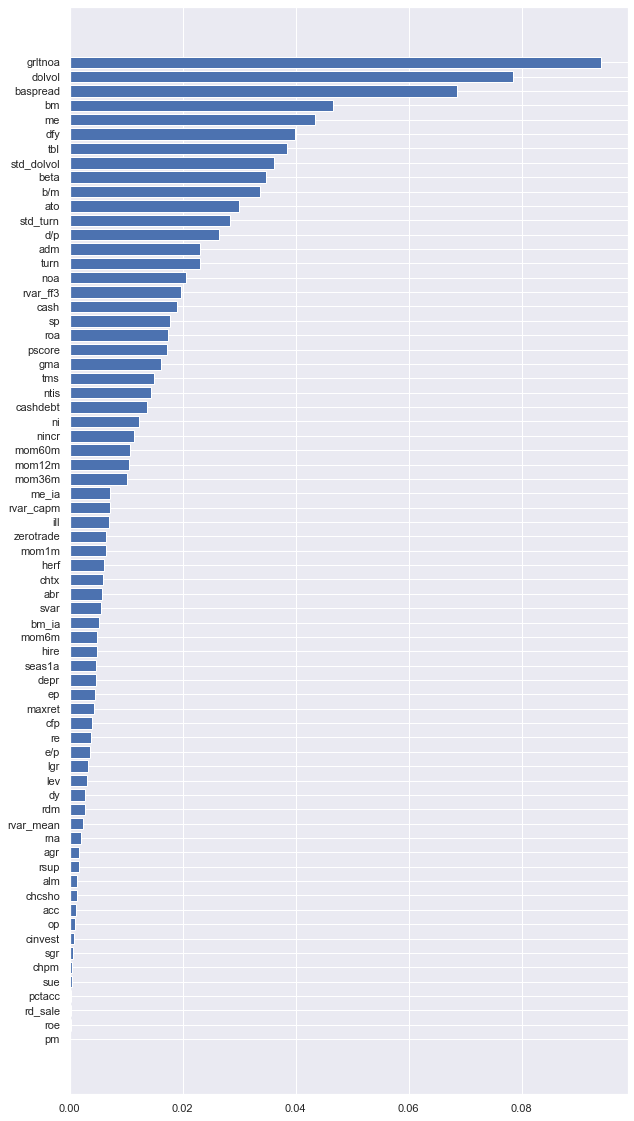

In [141]:
NN5_FI = pd.DataFrame(rsquared_normalized['NN5'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN5_FI.index, NN5_FI['NN5'])
plt.show()

## parameter

In [ ]:
params ={
    'learning_rate':(0.001, 0.01),
    'k_reg': [regularizers.l1(10e−5, 10e−3)]
}

## 草稿

In [490]:
a = pd.date_range('19720101','19750101',freq='AS-JAN')
a

DatetimeIndex(['1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01'], dtype='datetime64[ns]', freq='AS-JAN')

In [492]:
for start_date in tqdm(a):
    start_date = a[3] # test
    end_date = start_date + 32 * YearEnd()
    valid_date = end_date + 7 * YearEnd() 
    test_date = valid_date + 7 * YearEnd()
    
#     start_date = start_date.strftime('%Y%m%d') # 转化成字符型
#     end_date = end_date.strftime('%Y%m%d')
#     valid_date = valid_date.strftime('%Y%m%d')
    

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4490.69it/s]


In [493]:
start_date

Timestamp('1975-01-01 00:00:00', freq='AS-JAN')

In [494]:
end_date

Timestamp('2006-12-31 00:00:00', freq='AS-JAN')

In [495]:
valid_date

Timestamp('2013-12-31 00:00:00', freq='AS-JAN')

In [496]:
test_date

Timestamp('2020-12-31 00:00:00', freq='AS-JAN')

In [497]:
train_x = X_total.loc[start_date.strftime('%Y%m%d'):end_date.strftime('%Y%m%d')]

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_7121/3218650665.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_x = X_total.loc[start_date.strftime('%Y%m%d'):end_date.strftime('%Y%m%d')]


In [144]:
train_x

,sic,adm,bm_ia,herf,hire,...,svar,d/p,e/p,dfy,tms
date,,,,,,,,,,,
1972-01-31,-0.369620,-0.266273,0.060930,1.331469,-0.018029,...,-0.373084,-0.252113,0.126767,-0.107256,0.42651
1972-01-31,-0.255454,0.014889,-0.276326,-0.500789,-0.010624,...,-0.373084,-0.252113,0.126767,-0.107256,0.42651
1972-01-31,0.349179,0.014889,0.113205,2.258603,-0.021854,...,-0.373084,-0.252113,0.126767,-0.107256,0.42651
1972-01-31,0.056561,-0.040853,-0.850659,-0.833250,-0.016621,...,-0.373084,-0.252113,0.126767,-0.107256,0.42651
1972-01-31,-0.385692,0.014889,1.557838,-0.219789,-0.013646,...,-0.373084,-0.252113,0.126767,-0.107256,0.42651
...,...,...,...,...,...,...,...,...,...,...,...
1999-12-31,-0.385692,0.026540,-1.461352,-0.025041,-0.013646,...,-0.248607,1.948820,1.222879,-0.999526,-0.43688
1999-12-31,-0.872280,-0.246817,-0.196741,-0.718728,-0.013646,...,-0.248607,1.948820,1.222879,-0.999526,-0.43688
1999-12-31,1.640466,-0.253714,-0.062528,0.418700,-0.013646,...,-0.248607,1.948820,1.222879,-0.999526,-0.43688


In [457]:
a = pd.DataFrame(data = [], columns=['NN1','NN2'], index = [1,2,3])

In [25]:
rsquared = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=features_list)

In [26]:
rsquared

,NN1,NN2,NN3,NN4,NN5
sic,NaN,NaN,NaN,NaN,NaN
adm,NaN,NaN,NaN,NaN,NaN
bm_ia,NaN,NaN,NaN,NaN,NaN
herf,NaN,NaN,NaN,NaN,NaN
hire,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
shrcd_10.0,NaN,NaN,NaN,NaN,NaN
shrcd_11.0,NaN,NaN,NaN,NaN,NaN
exchcd_1.0,NaN,NaN,NaN,NaN,NaN
exchcd_2.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(np.zeros((123,1) * 5) * 5)

In [27]:
len(rsquared)

123

In [38]:
rsquared['NN1'] = np.zeros((len(rsquared),1)).tolist()

In [ ]:
rsquared.loc['sic','NN1']

In [43]:
rsquared.loc['sic','NN1'].append(1)

In [47]:
np.mean(rsquared.loc['sic','NN1'][1:])

1.0

In [486]:
type(rsquared.loc['sic','NN1'])

str

In [503]:
a = pd.DataFrame(columns=[1,2,3,4], index = [1,2,3,4])

In [514]:
a.replace(np.NaN, '[1]', inplace=True)

In [515]:
a

,1,2,3,4
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [509]:
np.zeros(1).tolist()

[0.0]

In [70]:
a = pd.DataFrame()

In [74]:
a['NN1'] = [[0],[0],[0]]
a['NN2'] = [[0],[0],[0]]

In [82]:
a

,NN1,NN2
0,"[0, 3, 3, 3, 3]","[0, 3, 3, 3, 3]"
1,"[0, 3, 3, 3, 3]","[0, 3, 3, 3, 3]"
2,"[0, 3, 3, 3, 3]","[0, 3, 3, 3, 3]"


In [88]:
a.iloc[::2]

,NN1,NN2
0,"[0, 3, 3, 3, 3]","[0, 3, 3, 3, 3]"
2,"[0, 3, 3, 3, 3]","[0, 3, 3, 3, 3]"


In [81]:
a.loc[0, 'NN1'].append(3)
a.loc[1, 'NN1'].append(3)
a.loc[2, 'NN1'].append(3)
a.loc[0, 'NN2'].append(3)
a.loc[1, 'NN2'].append(3)
a.loc[2, 'NN2'].append(3)

In [254]:
x = a.copy()

In [276]:
x

,NN1,NN2
0,"[0, 1, 2, 3]","[0, 1, 2, 3]"
1,"[0, 1, 2, 3]","[0, 1, 2, 3]"
2,"[0, 1, 2, 3]","[0, 1, 2, 3]"


In [278]:
x['nn1'] = pd.DataFrame(x['NN1'].values.tolist()).drop(0,1).values.tolist()

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_7121/2815039839.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x['nn1'] = pd.DataFrame(x['NN1'].values.tolist()).drop(0,1).values.tolist()


In [282]:
x['nn1']= x['nn1'].apply(np.mean)

In [283]:
x

,NN1,NN2,nn1
0,"[0, 1, 2, 3]","[0, 1, 2, 3]",2.0
1,"[0, 1, 2, 3]","[0, 1, 2, 3]",2.0
2,"[0, 1, 2, 3]","[0, 1, 2, 3]",2.0


In [243]:
a['NN1']

0    [0, 1, 1, 1, 1]
1    [0, 1, 1, 1, 1]
2    [0, 1, 1, 1, 1]
Name: NN1, dtype: object

In [452]:
a['NN2'].apply(np.mean)

1    1.5
2    2.0
3    2.5
Name: NN2, dtype: float64

In [48]:
def model():
    a = 1
    b = 2
    c = 3
    return a, b, c

AttributeError: 'tuple' object has no attribute 'b'

In [143]:
features_list

['adm',
 'bm_ia',
 'herf',
 'hire',
 'me_ia',
 'baspread',
 'beta',
 'ill',
 'maxret',
 'mom12m',
 'mom1m',
 'mom36m',
 'mom60m',
 'mom6m',
 're',
 'rvar_capm',
 'rvar_ff3',
 'rvar_mean',
 'seas1a',
 'std_dolvol',
 'std_turn',
 'zerotrade',
 'me',
 'dy',
 'turn',
 'dolvol',
 'abr',
 'sue',
 'cinvest',
 'nincr',
 'pscore',
 'acc',
 'bm',
 'agr',
 'alm',
 'ato',
 'cash',
 'cashdebt',
 'cfp',
 'chcsho',
 'chpm',
 'chtx',
 'depr',
 'ep',
 'gma',
 'grltnoa',
 'lev',
 'lgr',
 'ni',
 'noa',
 'op',
 'pctacc',
 'pm',
 'rd_sale',
 'rdm',
 'rna',
 'roa',
 'roe',
 'rsup',
 'sgr',
 'sp',
 'b/m',
 'tbl',
 'ntis',
 'svar',
 'd/p',
 'e/p',
 'dfy',
 'tms',
 'ffi49_1',
 'ffi49_2',
 'ffi49_3',
 'ffi49_4',
 'ffi49_5',
 'ffi49_6',
 'ffi49_7',
 'ffi49_8',
 'ffi49_9',
 'ffi49_10',
 'ffi49_11',
 'ffi49_12',
 'ffi49_13',
 'ffi49_14',
 'ffi49_15',
 'ffi49_16',
 'ffi49_17',
 'ffi49_18',
 'ffi49_19',
 'ffi49_21',
 'ffi49_22',
 'ffi49_23',
 'ffi49_24',
 'ffi49_25',
 'ffi49_26',
 'ffi49_27',
 'ffi49_28',
 'ffi49_29

https://github.com/AdamTseng1208/Empirical-Asset-Pricing-with-ML/blob/master/EmpiricalAssetPricing_MachineLearning.py